# Ensemble Models
#### BSAN6070 CA-04 <br> Tina Brauneck<br>3/22/2025

<br>Description: <br>This program uses ensemble models, including Random Forest, AdaBoost, Gradient Boost, and XGB to predict a target class (>50K or <=50K). The process begins with data exploration and pre-processing. It includes examples of hyperparameter tuning, using graphs to find the optimal value, as well as an example of k-fold cross validation and GridSearchCV to find best combinations of values. The program compares the performance of the four different ensemble models, using the optimal n_estimators value for each. All other hyperparameters are kept at default in the comparison. <br><br>

### Table of Contents
##### &emsp; Step 1: Data Exploration and Pre-processing

&emsp; &emsp; &emsp; Setup <br>
&emsp; &emsp; &emsp; Data Quality Report <br>
&emsp; &emsp; &emsp; Missing Data Checks <br>
&emsp; &emsp; &emsp; Cardinality Checks <br>
&emsp; &emsp; &emsp; Bar Charts <br>
&emsp; &emsp; &emsp; Correlation <br>
&emsp; &emsp; &emsp; Pre-processing <br>

##### &emsp; Step 2: Modeling

&emsp; &emsp; &emsp; Model Setup <br>
&emsp; &emsp; &emsp; Random Forest <br>
&emsp; &emsp; &emsp; Hyperparameter Tuning <br>
&emsp; &emsp; &emsp; AdaBoost <br>
&emsp; &emsp; &emsp; Gradient Boost <br>
&emsp; &emsp; &emsp; XGB <br>
&emsp; &emsp; &emsp; Choosing the Model <br>

##### &emsp; Step 3: Predictor

&emsp; &emsp; &emsp; User Input <br>
&emsp; &emsp; &emsp; Prediction

 <br><br>

## Step 1: Data Exploration & Pre-processing

### Setup

Environment setup and package imports:

In [14]:
# Optional installations. Uncomment and install if not already installed. It is recommended that you run one line at a time.
# pip install plotnine pandas
## pip install plotly
# pip install girth
# pip install --upgrade bottleneck
# pip install semopy
# conda install python-graphviz
# pip install xgboost

In [15]:
#Package imports:

# Basic visualization and data handling
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_histogram, facet_wrap, geom_bar
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Performance Visualization
from matplotlib.legend_handler import HandlerLine2D

These next few steps put our data into a dataframe and provide a first look at the data.

In [18]:
df = pd.read_csv(r"https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true") # read in the data

In [19]:
## print the DataFrame's shape, i.e., number of rows and columns
print(df.shape)

(48842, 11)


In [20]:
df.head() #preview the data

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [21]:
df.tail() #preview the data

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
48837,b. 31-40,e. High,b. Mid,a. = 0,b. Mid,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,test,0
48838,b. 31-40,b. Mid - Low,a. Low,a. = 0,b. Mid,b. 9-12,b. Mid,a. no income,c. 31-35 & 61-70,test,0
48839,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,test,0
48840,b. 31-40,b. Mid - Low,a. Low,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,test,0
48841,e. 51-60,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,c. 31-35 & 61-70,test,1


In [22]:
df.dtypes # This function determines if the feature is categorial or numerical

hours_per_week_bin    object
occupation_bin        object
msr_bin               object
capital_gl_bin        object
race_sex_bin          object
education_num_bin     object
education_bin         object
workclass_bin         object
age_bin               object
flag                  object
y                      int64
dtype: object

### Data Quality Report

In [25]:
# Setting display options so that the report will be readable
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [26]:
pd.set_option('display.width', 1000)

In [27]:
# Custom function for creating a data quality report

def data_quality_report(df, report_type):
    continuous_rows = []
    categorical_rows = []
    
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]): 
            count = df[col].count()
            missing_percentage = df[col].isnull().mean() * 100
            cardinality = df[col].nunique()
            first_quartile = df[col].quantile(0.25)
            mean = df[col].mean()
            median = df[col].median()
            third_quartile = df[col].quantile(0.75)
            max_value = df[col].max()
            std_dev = df[col].std()
            
            continuous_rows.append({
                'Feature': col,
                'Count': count,
                '% Missing': missing_percentage,
                'Card.': cardinality,
                '1st Qrt.': first_quartile,
                'Mean': mean,
                'Median': median,
                '3rd Qrt.': third_quartile,
                'Max': max_value,
                'Std. Dev.': std_dev
            })

        else:
            count = df[col].count()
            missing_percentage = df[col].isnull().mean() * 100
            cardinality = df[col].nunique()
            value_counts = df[col].value_counts()
            mode = value_counts.index[0] if not value_counts.empty else 'NA'
            mode_freq = value_counts.iloc[0] if not value_counts.empty else 0
            mode_percentage = (mode_freq / count) * 100 if count > 0 else 0
            second_mode = value_counts.index[1] if len(value_counts) > 1 else 'NA'
            second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else 0
            second_mode_percentage = (second_mode_freq / count) * 100 if count > 0 else 0

            categorical_rows.append({
                'Feature': col,
                'Count': count,
                '% Missing': missing_percentage,
                'Card.': cardinality,
                'Mode': mode,
                'Mode Freq.': mode_freq,
                'Mode %': mode_percentage,
                '2nd Mode': second_mode,
                '2nd Mode Freq.': second_mode_freq,
                '2nd Mode %': second_mode_percentage
            })

    continuous_report = pd.DataFrame(continuous_rows)
    categorical_report = pd.DataFrame(categorical_rows)

    if report_type == "cont":
        return continuous_report

    elif report_type == "cat":
        return categorical_report
        
    else:
        raise ValueError("Error: report type options are 'cat' or 'cont'")

In [28]:
dqr_cont = data_quality_report(df,"cont")

In [29]:
dqr_cat = data_quality_report(df,"cat")

#### Data Quality Report: Continuous Features

In [31]:
dqr_cont

,Feature,Count,% Missing,Card.,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std. Dev.
0,y,48842,0.0,2,0.0,0.239282,0.0,0.0,1,0.426649


This is our target feature.

#### Data Quality Report: Categorical Features

In [34]:
dqr_cat

,Feature,Count,% Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,hours_per_week_bin,48842,0.0,5,b. 31-40,26639,54.541174,d. 41-50 & 61-70,9819,20.103599
1,occupation_bin,48842,0.0,5,c. Mid - Mid,13971,28.604480,b. Mid - Low,12947,26.507924
2,msr_bin,48842,0.0,3,c. High,22047,45.139429,b. Mid,15868,32.488432
3,capital_gl_bin,48842,0.0,3,a. = 0,42525,87.066459,c. > 0,4035,8.261332
4,race_sex_bin,48842,0.0,3,c. High,29737,60.884075,b. Mid,16457,33.694361
5,education_num_bin,48842,0.0,5,b. 9-12,30324,62.085910,c. 13,8025,16.430531
6,education_bin,48842,0.0,5,b. Mid,30324,62.085910,c. Bachelors,8025,16.430531
7,workclass_bin,48842,0.0,2,b. income,46012,94.205806,a. no income,2830,5.794194
8,age_bin,48842,0.0,5,e. 40-55,13963,28.588100,a. 0-25,9627,19.710495
9,flag,48842,0.0,2,train,32561,66.665984,test,16281,33.334016


#### Missing Data Checks

Show features with more than 60% of observations missing data.

In [37]:
dqr_cat[dqr_cat['% Missing'] > 60]

,Feature,Count,% Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %


In [38]:
dqr_cont[dqr_cont['% Missing'] > 60]

,Feature,Count,% Missing,Card.,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std. Dev.


There is no missing data in this dataset.

#### Cardinality Checks

Next, we check for unusually high or low cardinality.

In [42]:
# Checking for features with a cardinality of 1. 
# If a feature has cardinality of 1, we drop it, because it has no use; all the values are the same.
dqr_cat[dqr_cat['Card.'] == 1]

,Feature,Count,% Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %


In [43]:
# Same check for the continuous features
dqr_cont[dqr_cont['Card.'] == 1]

,Feature,Count,% Missing,Card.,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std. Dev.


In [44]:
# Checking for continuous features that have too low a cardinality. These may actually be encoded categorical features.
dqr_cont[dqr_cont['Card.'] < 30]

,Feature,Count,% Missing,Card.,1st Qrt.,Mean,Median,3rd Qrt.,Max,Std. Dev.
0,y,48842,0.0,2,0.0,0.239282,0.0,0.0,1,0.426649


This is our target column and it has a binary encoding of 0 and 1.

In [46]:
# Assign any encoded categorical columns to cont_convert so they are graphed as if they are categorical.
cont_convert = 'y'

In [47]:
# Checking for categorical features that have too high a cardinality. These may just be unique identifiers and can be dropped.
dqr_cat[dqr_cat['Card.'] > 50]

,Feature,Count,% Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %


Our features are binned, so, as expected, they all have relatively low cadinality.

In [49]:
# Make a copy of the dataframe and assign it as our analytics base table (abt). The original df will remain unaltered.
abt=df.copy()

### Data Exploration

To start exploring, we divide the ABT dataframe into two feature sets: continuous features and categorical features.

In [52]:
# Declare empty lists for the categorical columns and the continuous columns
categorical_cols = []
continuous_cols = []

#Define continuous and categorial columns from the abt:
for col in abt.columns:
    if pd.api.types.is_numeric_dtype(abt[col]):
        continuous_cols.append(col)
    else:
        categorical_cols.append(col)

# Transfer any continous columns that were identified as encoded categorical columns in the cardinality checks.
continuous_cols.remove(cont_convert)
categorical_cols.append(cont_convert)

In [53]:
# Check the output
abt[categorical_cols].head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [54]:
# Check the output
abt[continuous_cols].head()

""
0
1
2
3
4


Since all our data is binned or encoded, we have no continuous columns.

#### Bar Plots

All of our data can be graphed using bar charts, since it came binned.

In [58]:
from plotnine import (
    ggplot, aes, geom_bar, facet_wrap, theme_classic, theme, element_text, ggsave)

# Melt categorical columns for visualization
abt_cat_melted = abt[categorical_cols].melt(var_name='column', value_name='value')

# Design bar plots 
cat_plot = (
    ggplot(abt_cat_melted, aes(x='value')) +
    geom_bar(fill='deepskyblue', color='black', size=0.1) +  # Add thin line around bars
    facet_wrap('~column', nrow=12, ncol=3, scales='free_x') +
    theme_classic() +  # Apply classic theme
    theme(
        panel_spacing=0.005,  # Adjust space between panels
        figure_size=(10, 12),  # Increase the figure size (width, height)
        strip_text_x=element_text(size=8),  # Increase facet label size
        axis_text_x=element_text(size=9, angle=20),
        axis_text=element_text(size=8),  # Increase axis text size
        axis_title=element_text(size=11),  # Adjust axis title size
        # plot_title=element_text(size=36)  # Uncomment for plot title size
    )
)

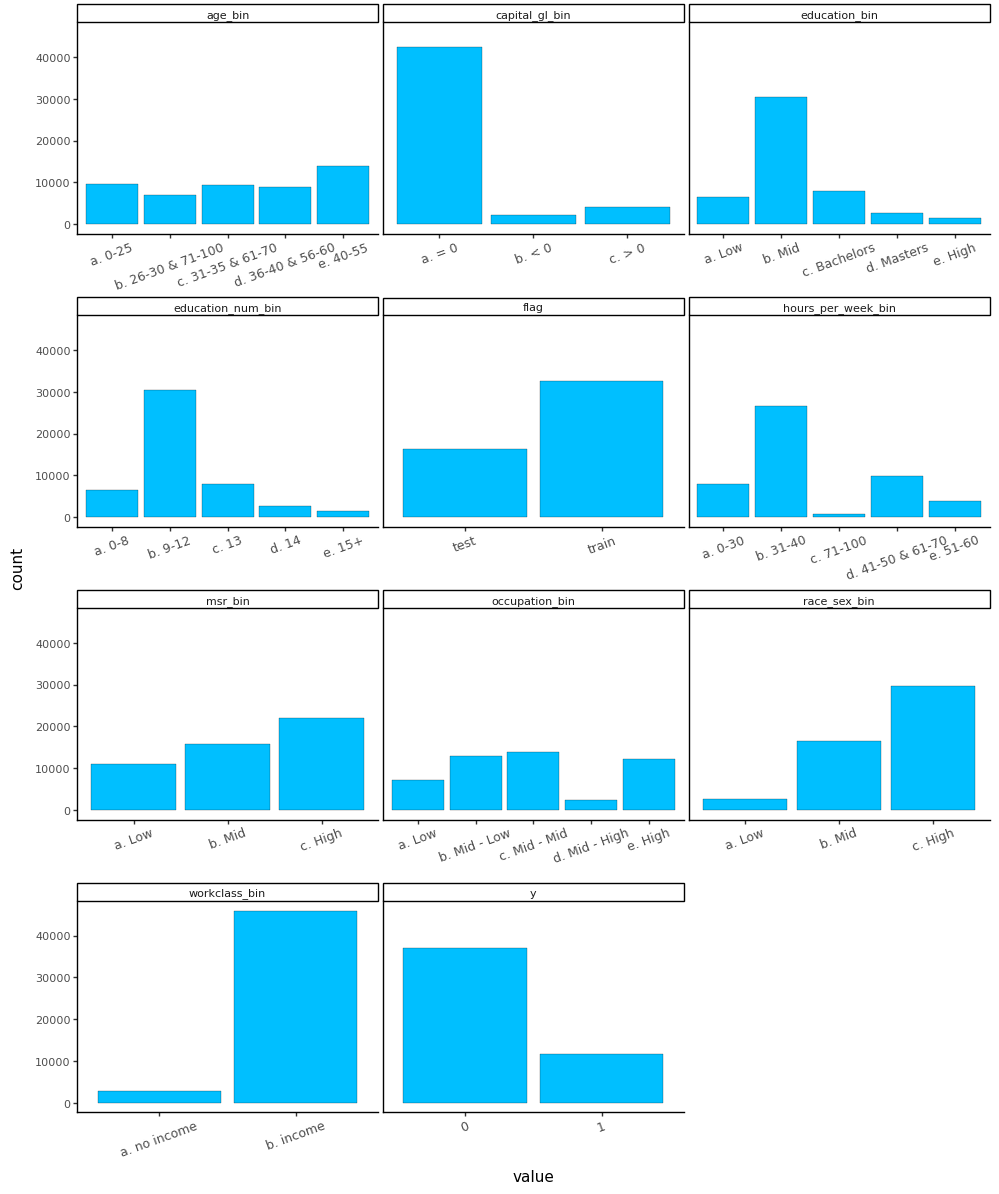

In [59]:
cat_plot.draw()

##### Bar Plots By Class and Feature

Next, we explore relationships in our data by comparing the fequency of out target class (>$50K) to the fequency of those outside that class, across different features.

In [62]:
# Melt categorical columns for visualization
abt_cat_melted = abt.melt(id_vars=['y'], value_vars=categorical_cols, var_name='column', value_name='value')

# Design bar plots 
y_plot = (
    ggplot(abt_cat_melted, aes(x='value', fill='factor(y)')) +
    geom_bar(position='dodge', color='black', size=0.1) +  # Add thin line around bars
    facet_wrap('~column', nrow=12, ncol=3, scales='free_x') +
    theme_classic() +  # Apply classic theme
    theme(
        panel_spacing=0.005,  # Adjust space between panels
        figure_size=(10, 12),  # Increase the figure size (width, height)
        strip_text_x=element_text(size=8),  # Increase facet label size
        axis_text_x=element_text(size=9, angle=20),
        axis_text=element_text(size=8),  # Increase axis text size
        axis_title=element_text(size=11),  # Adjust axis title size
    )
)

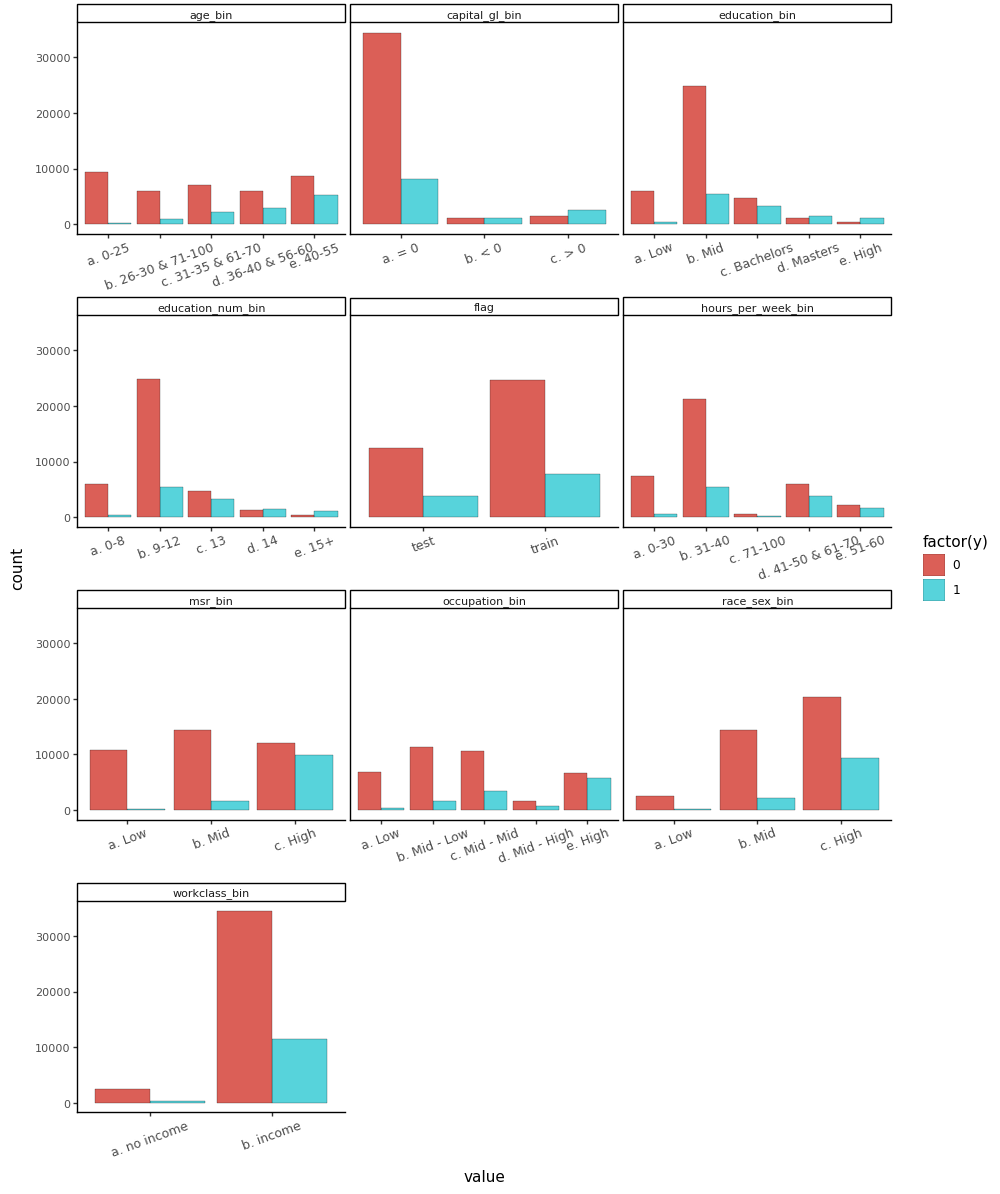

In [63]:
y_plot.draw()

From this visualization, it looks like our target class of >50K ('1') is associated with the 'income' workclass, 'high' race_sex, 'high' msr, and education level of a bachelors degree and above. Note that the relative frequency of the target class '1' is higher for these features than the others; the aqua bars are closer in size to the adjacent red bar in these features. The highest relative frequency of our target class '1' is associated with the 40-55 age group. 

<br>

### Cramer's V Correlation Matrix

In order to understand the relationship between features, we will use a correlation matrix. Cramer's matrix is suitable for categorical variables and ranges from 0 (no association) to 1 (high association).

In [68]:
abt_e = abt.drop(['flag'], axis = 1, inplace=False)

In [69]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

In [70]:
rows= []

for var1 in abt_e:
  col = []
  for var2 in abt_e :
    cramers =cramers_V(abt_e[var1], abt_e[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
matrix = pd.DataFrame(cramers_results, columns = abt_e.columns, index =abt_e.columns)

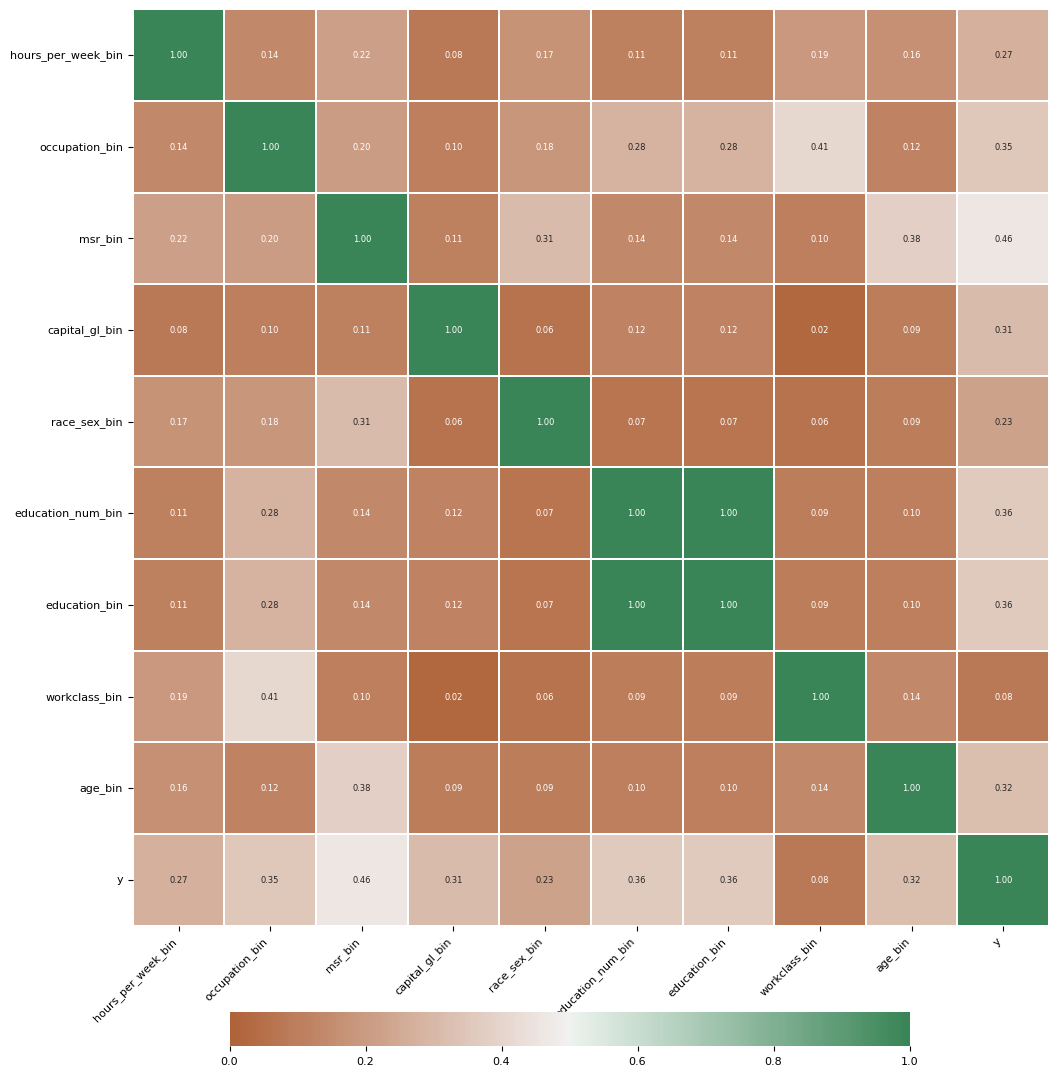

In [71]:
plt.figure(figsize=(17, 17))

axis_corr = sns.heatmap(
matrix,
vmin=0, vmax=1, center=0.5,
cmap=sns.diverging_palette(30, 500, n=500),
    square=True,
    annot=True,  # Show correlation coefficients in each square
    fmt=".2f", # Format the coefficients to 2 decimal places
    annot_kws={"size": 6},  # Set font size for correlation coefficients
    linewidths=.1,  # Add lines between squares for better visibility
    cbar_kws={"shrink": .60, "orientation": "horizontal"}  # Adjust color bar (legend) size
)

# Sets the font size and rotation for the x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# Adjust the position of the color legend
cbar = axis_corr.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_position([0.2, 0.27, 0.6, 0.02])

#for text in axis_corr.texts:
    #text.set_visible(True)

plt.show()

This matrix shows us that the number of years of education bin is perfectly correlated with the education level bin. We can eliminate one of these features to improve our model. <br>
There are no other correlations strong enough to warrant feature removal.

In [73]:
abt.drop('education_bin', axis = 1, inplace = True)

### Pre-Processing

#### Imputation and Calculations

In [76]:
dqr_cat[dqr_cat['% Missing'] > 0]

,Feature,Count,% Missing,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %


There are no missing values, so we do not need to omit or impute data.

#### Outlier Handling

Given that our data has been binned already, there are no outliers to remove. Removing bins would create null predictions, so we will keep even the smallest bins.

#### Encoding

We will encode oridinal features using label encoding. The data is already in ranking order, with a letter prefix, so we can use that prefix to maintain the order for the encoding.

In [82]:
# Function to encode a column based on its prefix.
# All the binned data starts with a letter, which we will use to map the label encoding.
def encode_column(column):
    column = column.astype(str)
    # Extract prefixes and suffixes
    prefixes = column.str[0]
    suffixes = column.str[1:]
    
    # Get unique prefixes and sort them
    unique_prefixes = sorted(prefixes.unique())
    prefix_mapping = {prefix: idx + 1 for idx, prefix in enumerate(unique_prefixes)}
    
    # Encode prefixes
    encoded_prefixes = prefixes.map(prefix_mapping)
    
    # Combine encoded prefixes with suffixes
    encoded_column = encoded_prefixes.astype(int)
    
    return encoded_column

In [83]:
# Make a copy of the abt. This will be encoded.
abt_encoded = abt.copy()

# Apply encoding to each column
for col in ['occupation_bin', 'msr_bin', 'race_sex_bin', 'education_num_bin']:
    abt_encoded[col + '_Encoded'] = encode_column(abt_encoded[col])

In [84]:
abt_encoded.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,workclass_bin,age_bin,flag,y,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,b. income,d. 36-40 & 56-60,train,0,2,2,3,3
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,b. income,e. 40-55,train,0,5,3,3,3
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. income,d. 36-40 & 56-60,train,0,1,2,3,2
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,b. income,e. 40-55,train,0,1,3,2,1
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,b. income,b. 26-30 & 71-100,train,0,5,3,1,3


Now we must encode the nominal features.

In [86]:
# One-Hot Encoding for nominal columns
nominal_columns = ['age_bin', 'capital_gl_bin', 'hours_per_week_bin', 'workclass_bin']
abt_encoded = pd.get_dummies(abt_encoded, columns=nominal_columns)

In [87]:
abt_encoded.head()

,occupation_bin,msr_bin,race_sex_bin,education_num_bin,flag,y,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55,capital_gl_bin_a. = 0,capital_gl_bin_b. < 0,capital_gl_bin_c. > 0,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,workclass_bin_a. no income,workclass_bin_b. income
0,b. Mid - Low,b. Mid,c. High,c. 13,train,0,2,2,3,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,e. High,c. High,c. High,c. 13,train,0,5,3,3,3,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,a. Low,b. Mid,c. High,b. 9-12,train,0,1,2,3,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,a. Low,c. High,b. Mid,a. 0-8,train,0,1,3,2,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4,e. High,c. High,a. Low,c. 13,train,0,5,3,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [88]:
# Drop the old columns, keeping only the encoded columns
abt_encoded = abt_encoded.iloc[:,4:]   
abt_encoded.head()

,flag,y,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55,capital_gl_bin_a. = 0,capital_gl_bin_b. < 0,capital_gl_bin_c. > 0,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,workclass_bin_a. no income,workclass_bin_b. income
0,train,0,2,2,3,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,train,0,5,3,3,3,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,train,0,1,2,3,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,train,0,1,3,2,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4,train,0,5,3,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [89]:
abt_prepped = abt_encoded.copy()

In [90]:
# Some models cannot accept special characters in the column name, so we must rename them.
# Define a mapping for renaming columns
rename_mapping = {
    'flag': 'flag',
    'y':'y',
    'age_bin_a. 0-25': 'age_bin_0_25',
    'age_bin_b. 26-30 & 71-100': 'age_bin_26_30_71_100',
    'age_bin_c. 31-35 & 61-70': 'age_bin_31_35_61_70',
    'age_bin_d. 36-40 & 56-60': 'age_bin_36_40_56_60',
    'age_bin_e. 40-55': 'age_bin_40_55',
    'capital_gl_bin_a. = 0': 'capital_gl_0',
    'capital_gl_bin_b. < 0': 'capital_gl_less_thn_0',
    'capital_gl_bin_c. > 0': 'capital_gl_greater_thn_0',
    'hours_per_week_bin_a. 0-30': 'hours_per_week_0_30',
    'hours_per_week_bin_b. 31-40': 'hours_per_week_31_40',
    'hours_per_week_bin_c. 71-100': 'hours_per_week_71_100',
    'hours_per_week_bin_d. 41-50 & 61-70': 'hours_per_week_41_50_61_70',
    'hours_per_week_bin_e. 51-60': 'hours_per_week_51_60',
    'workclass_bin_a. no income': 'workclass_no_income',
    'workclass_bin_b. income': 'workclass_income'
}

# Rename columns
abt_prepped.rename(columns=rename_mapping, inplace=True)

<br>

## Step 2: Modeling

### Model Setup

In this section, we prepare for modeling by setting a random seed (for consistency) and split the data into training and testing sets.

In [95]:
np.random.seed(890) 
#By setting a random seed, we can leave comments about performance that will still be accurate when the code is reviewed.
#This can be commented out to restore a truly random output, but note that all comments on performance were made with random seed set to 890.

In [96]:
# Split the abt into two sets, one for training and one for validation.
train = abt_prepped[abt_prepped['flag'] == 'train']
test = abt_prepped[abt_prepped['flag'] == 'test']

In [97]:
# Split both the training an test sets into x (attributes) and y (taret features)
x_train = train.drop(['y','flag'], axis=1, inplace = False)
y_train = train['y']

x_test = test.drop(['y','flag'], axis=1, inplace = False)
y_test = test['y']

In [98]:
x_train.head()

,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_0_25,age_bin_26_30_71_100,age_bin_31_35_61_70,age_bin_36_40_56_60,age_bin_40_55,capital_gl_0,capital_gl_less_thn_0,capital_gl_greater_thn_0,hours_per_week_0_30,hours_per_week_31_40,hours_per_week_71_100,hours_per_week_41_50_61_70,hours_per_week_51_60,workclass_no_income,workclass_income
0,2,2,3,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,5,3,3,3,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,1,2,3,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,1,3,2,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4,5,3,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


### Random Forest Model

Now it's time to build the first model. We start with a basic Random Forest model, using only default hyperparameters.

In [101]:
rf = RandomForestClassifier(random_state=890) # Define the model type and its hyperparameters
rf.fit(x_train, y_train) # train the model

RandomForestClassifier(random_state=890)

In [102]:
y_pred=rf.predict(x_test)

#### Performance Check

Next, we compare the model predictions to the actuals. A confusion matrix shows us how many predictions of the target class '1' were actually in the target class '1' (true positive or 1:1) as well as how many predictions in the target class '1' actually were not in the target class '1' (false positive or 0:1).

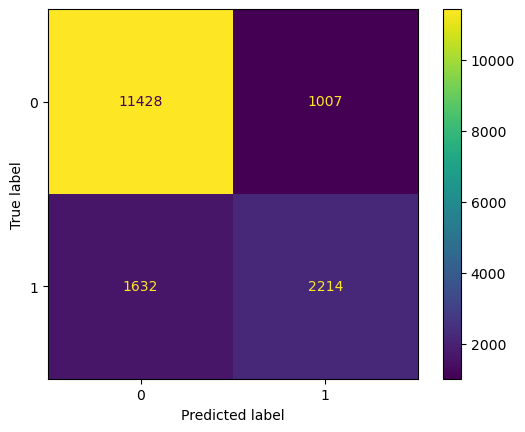

In [105]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

Here, we see our model had 2,214 true positives, 11,428 true negatives, 1007 false positives, and 1,632 false negatives. Observe that the target feature has less positive observations than the remainder of the dataset, so our true negatives will be substatially higher than our true positives.

Let's review all of the important performance metics. To do this, we define a custom function we can call after training each model variant.

In [108]:
# Creating a function for reporting performance parameters

def perf(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    perf_results = pd.DataFrame({'Accuracy': [accuracy], 'Recall':[recall], 'Precision':[precision], 'F1 Score':[f1], 'AUC': [roc_auc]})

    return display(perf_results.style.hide(axis="index")) #displays a dataframe of all the performance metrics

In [109]:
perf(y_test, y_pred) # output performance metrics

Accuracy,Recall,Precision,F1 Score,AUC
0.837909,0.747341,0.781201,0.761532,0.747341


The model has an 84% accuracy using the default hyperparameters. The F1 score is only 76%, suggesting there may be some bias. 
Next, we will tune the model using different hyperparameters to improve the performance.
<br><br>

#### Random Forest Hyperparameter Tuning

##### Max_depth

First, we'll try varying maximum depth to better understand hyperparameter tuning.

In [114]:
max_depths = range(1, 20) # defines a list of values to try for max_depth
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

# loop through various values of max_depth and store the results
for max_depth in max_depths:
    # train with hyperparameter
    rf = RandomForestClassifier(max_depth=max_depth, random_state=890)
    rf.fit(x_train, y_train)

    #Predict results for training set and log metrics AUC and accuracy
    train_y_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metrics AUC and accuracy
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in max_depth

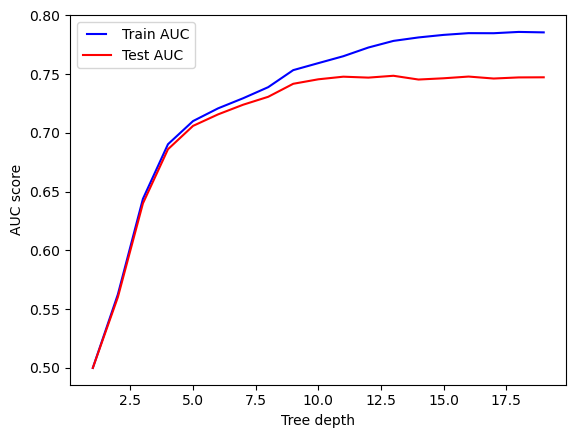

In [116]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(max_depths, train_auc, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [117]:
# outputs a table of the AUC results
max_depth_auc_results = pd.DataFrame({'max_depth': max_depths, 'AUC': test_auc})
max_depth_auc_results.reset_index(drop=True, inplace=True)
display(max_depth_auc_results[5:15].style.hide(axis="index"))

max_depth,AUC
6,0.715827
7,0.724046
8,0.730786
9,0.741865
10,0.745682
11,0.747911
12,0.747120
13,0.748691
14,0.745485
15,0.746550


Based on the graph, the optimum depth is 11. After 11, the AUC declines for the test dataset, indicating higher max depths result in overfitting.

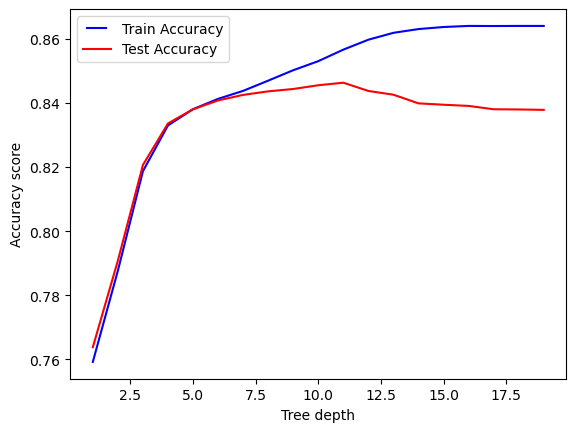

In [119]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(max_depths, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(max_depths, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

In [120]:
# outputs a table of the accuracy results
max_depth_acc_results = pd.DataFrame({'max_depth': max_depths, 'Accuracy': test_accuracy})
max_depth_acc_results.reset_index(drop=True, inplace=True)
display(max_depth_acc_results[5:15].style.hide(axis="index"))

max_depth,Accuracy
6,0.840796
7,0.842516
8,0.843621
9,0.844358
10,0.845525
11,0.846324
12,0.843744
13,0.842577
14,0.839875
15,0.839445


Accuracy peaks at 11. AUC also increases until a max_depth of 11, then begins a decline. 11 is the optimum maximum tree depth.

#### N_Estimators

Next, let's test different values of n_estimators to find the optimal value for this hyperparameter. N_estimators represents the number of decision trees used to generate the predicted classification. 

In [124]:
n_estimator_lst = range(50, 550,50) # defines a list of values to try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

for n_estimators in n_estimator_lst:
    # train with hyperparameter
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=890)
    rf.fit(x_train, y_train)

    #Predict results for training set and log metrics AUC and accuracy
    train_y_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metrics AUC and accuracy
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

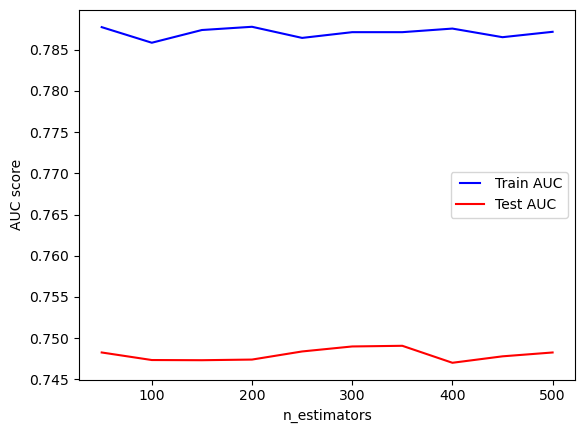

In [126]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

At 350, the AUC peaks for the test dataset, suggesting this is the optimal number of estimators.

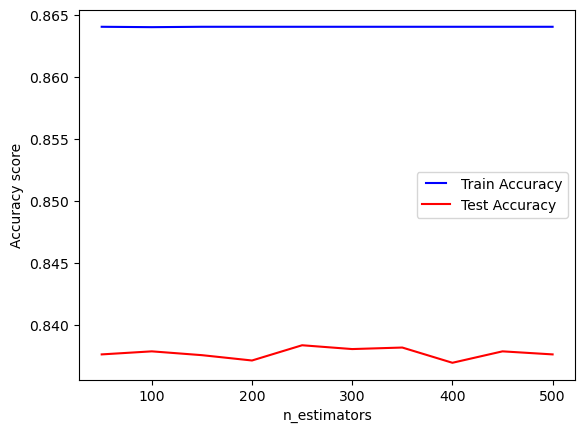

In [128]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

In [129]:
n_est_acc_results = pd.DataFrame({'Estimators': n_estimator_lst, 'Accuracy': test_accuracy})
n_est_acc_results.reset_index(drop=True, inplace=True)
display(n_est_acc_results[3:10].style.hide(axis="index"))

Estimators,Accuracy
200,0.837172
250,0.838401
300,0.838093
350,0.838216
400,0.836988
450,0.837909
500,0.837664


The accuracy graph shows random variation in the accuracy of the test data's predictions, with a local maximum of 350, similar to the AUC graph. While the accuracy at 250 is marginally higher, the difference is very slight. Accuracy, overall, varied less than .2%, so the AUC is more helpful in pinpointing the optimal value in this case.  The AUC curve shows a distinct pattern of increasing AUC as n_estimators increase, up to 350.  350 is the optimal value for n_estimators.

### K-Fold Cross Validation

Ultimately, our goal is to compare the different ensemble models and to do so, we will vary only n_estimators during tuning, leaving all other hyperparameters at default. Below is an example of k-fold cross validation. This section is purely demonstational and can be skipped without impact to the final comparison. <br> <br> This section demonstrates how k-fold cross validation can be used in tandem with GridSearchCV to find the optimal hyperparameter values for multiple hyperparameters simultantously.

In [133]:
# Note that K-fold cross validation is processor-intensive. It may take some time to run. 
# This section can be skipped.

In [134]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

model = RandomForestClassifier(random_state=890)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=890) # Classes are imbalanced; we have more 'y' than 'n' in the target feature, so 
#stratified folds are recommended.

gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(7, 12), # using only a narrow band of depths, based on the best values in the graph above
                                'n_estimators': range(200, 600, 50)}, # starting at 200; the above graph suggests less will not be as effective
                  cv=stratified_kfold, # number of folds (k); we are using a stratified 5-fold model
                  n_jobs=-1, # setting n_jobs to -1 uses all available cores for processing, speeding up the processing time for GridSearchCV
                  scoring='roc_auc') # since our dataset has class imbalance, AUC may be a better metric than accuracy

gs.fit(x_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 9, 'n_estimators': 450}
0.8971555113716834


Based on the cross-validation results, the best hyperparameters to use are max_depth = 9 and n_estimators = 450.

In [136]:
rf = RandomForestClassifier(n_estimators=450, max_depth=9, random_state=890)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=450, random_state=890)

In [137]:
y_pred=rf.predict(x_test)

In [138]:
perf(y_test, y_pred) # output performance metrics

Accuracy,Recall,Precision,F1 Score,AUC
0.845280,0.744084,0.799128,0.765049,0.744084


This accuracy score is better than using max_depth = 11 and n_estimators = 350, though the f1 score is not as high. Note that these hyperparameter values resulted in a lower AUC than in the 5-fold cross validated tuning. This may suggest a fundamental difference between our test dataset and our training dataset.

In [140]:
# Proportion of target class '1' in the test dataset
len(y_test[y_test==1])/len(y_test)

0.23622627602727106

In [141]:
# Proportion of target class '1' in the training dataset
len(y_train[y_train==1])/len(y_train)

0.2408095574460244

The class balance is similar but not the same for the test dataset as for the training dataset. This difference could have a slight impact on the performance metrics, but it is likely there are other differences in the training and test datasets accounting for this difference in performance. As cross-validation isn't the focus of this assignment, we will leave this finding aside. For simplicity, let's use n_estimators = 350, which had the highest AUC during individual hyperparameter tuning.

We will collect the performance metrics for our best performing value of n-estimators for each type of model below, and compare them. 
<br> &emsp; &emsp; &emsp;Random Forest
<br> &emsp; &emsp; &emsp;Adaboost
<br> &emsp; &emsp; &emsp;Gradient Boost
<br> &emsp; &emsp; &emsp;XGB
<br> For this assignment, we'll vary only the n_estimators to use in the final comparison.

<br>

#### Best Random Forest (n_estimators only)

In [146]:
rf = RandomForestClassifier(n_estimators=350, random_state=890)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=350, random_state=890)

In [147]:
y_pred=rf.predict(x_test)

In [148]:
perf(y_test, y_pred) # output performance metrics

Accuracy,Recall,Precision,F1 Score,AUC
0.838216,0.749069,0.781263,0.762686,0.749069


In [149]:
metrics_df = pd.DataFrame(columns=['Metric'])

def store_metrics(model_name):
    global metrics_df
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Create a dictionary of metrics
    metrics = {
        'Accuracy': acc,
        'AUC': roc_auc
    }
    
    # Add metrics to the DataFrame
    for metric, value in metrics.items():
        if metric not in metrics_df['Metric'].values:
            new_row = pd.DataFrame({'Metric': [metric]})
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
        metrics_df.loc[metrics_df['Metric'] == metric, model_name] = value

#    return metrics_df


In [150]:
store_metrics('Random Forest') # saving these metrics for comparison across models

### AdaBoost Model

First, we start with a basic AdaBoost Model.

In [153]:
ada = AdaBoostClassifier(random_state=890) # Defining the model type, and setting a random_state for consistency. All other hyperparameters are default.
ada.fit(x_train, y_train) # training the model using the training data
y_pred = ada.predict(x_test) # predict results based on the test data

In [154]:
perf(y_test, y_pred) # call custom function to report on performance

Accuracy,Recall,Precision,F1 Score,AUC
0.845034,0.747785,0.796584,0.766951,0.747785


Now that we have a baseline, showing the performance using the defaults, we will vary n_estimators and see if a different number of decision trees can perform better.

In [156]:
n_estimator_lst = range(50, 550,50) # defines a list of values to try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

for n_estimators in n_estimator_lst:
    # train with hyperparameter
    ada = AdaBoostClassifier(n_estimators=n_estimators, random_state=890)
    ada.fit(x_train, y_train)

    #Predict results for training set and log metics AUC and accuracy
    train_y_pred = ada.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metics AUC and accuracy
    y_pred = ada.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

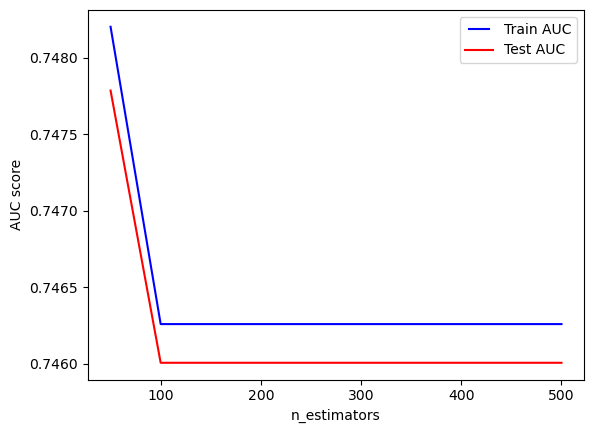

In [158]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

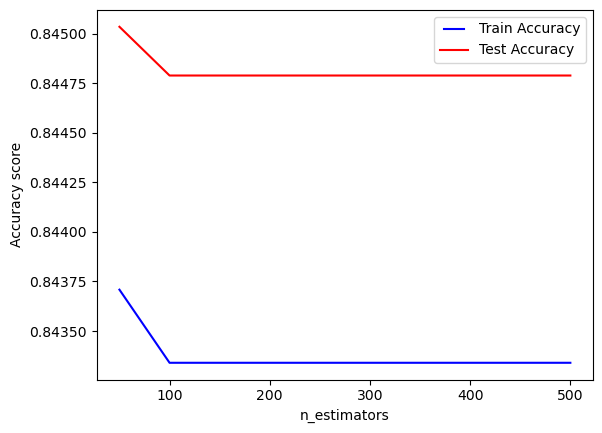

In [159]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

Optimal n_estimators is 50. In both graphs, there is a steep decline between 50 and 100 estimators, suggesting an increase in estimators degrades predictive ability.

In [161]:
ada = AdaBoostClassifier(n_estimators=50,random_state=890)
ada.fit(x_train, y_train)
y_pred = ada.predict(x_test)

In [162]:
perf(y_test, y_pred)

Accuracy,Recall,Precision,F1 Score,AUC
0.845034,0.747785,0.796584,0.766951,0.747785


In [164]:
store_metrics('Ada Boost') # saving these metrics for comparison across models

### Gradient Boost

Now let's start with a basic Gradient Boost model.

In [167]:
gb = GradientBoostingClassifier(random_state=890) # define model
gb.fit(x_train, y_train) #train
y_pred = gb.predict(x_test)

In [168]:
perf(y_test, y_pred) # output performance metrics

Accuracy,Recall,Precision,F1 Score,AUC
0.846631,0.757361,0.795790,0.773294,0.757361


Next, let's tune using n-estimators...

In [170]:
n_estimator_lst = range(50, 550,50) # creates a list of values we will try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

# loops through the different hyperparameter values and stores the performance
for n_estimators in n_estimator_lst:
    # train with hyperparameter
    gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=890)
    gb.fit(x_train, y_train)

    #Predict results for training set and log metics AUC and accuracy
    train_y_pred = gb.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metics AUC and accuracy
    y_pred = gb.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

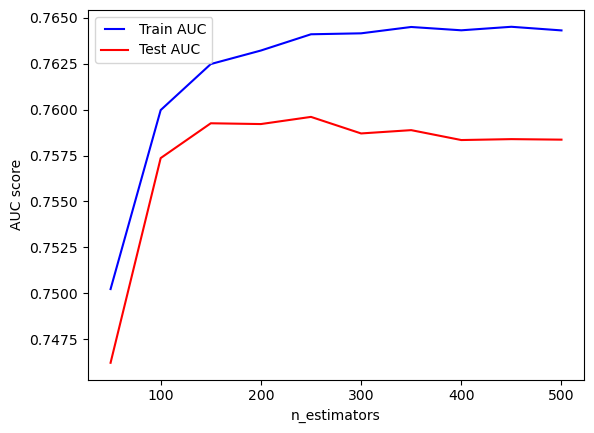

In [172]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

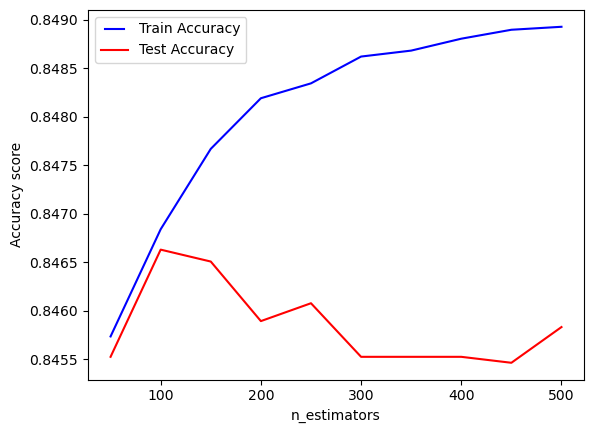

In [173]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

100 is the optimal value for n_estimators, out of those tested. The accuracy graph shows accuracy peaks at 100. The AUC increases until about 150, at which point the curve begins to flatten. The truly optimal value is likely somewhere between 100 and 150. Although AUC continues to increase after 100, it does so at a reduced rate. By comparing the slope of the test data curve at 150 to that of the training data, we can see that overfitting has started.

In [175]:
# generate a table showing the accuracy values
n_est_acc_results = pd.DataFrame({'Estimators': n_estimator_lst, 'Accuracy': test_accuracy})
n_est_acc_results.reset_index(drop=True, inplace=True)
display(n_est_acc_results[0:9].style.hide(axis="index"))

Estimators,Accuracy
50,0.845525
100,0.846631
150,0.846508
200,0.845894
250,0.846078
300,0.845525
350,0.845525
400,0.845525
450,0.845464


In [176]:
# Re-run the model using the optimal n_estimators value
gb = GradientBoostingClassifier(n_estimators=100,random_state=890)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

In [177]:
perf(y_test, y_pred)

Accuracy,Recall,Precision,F1 Score,AUC
0.846631,0.757361,0.795790,0.773294,0.757361


In [178]:
store_metrics('Gradient Boost') # saving these metrics for comparison across models

### Extreme Gradient Boosting (XGB)

Here, we start with a basic XGB model.

In [181]:
xgb = XGBClassifier(random_state=890) # define model
xgb.fit(x_train, y_train) #train
y_pred = xgb.predict(x_test) # predict

In [182]:
perf(y_test, y_pred) # output metrics

Accuracy,Recall,Precision,F1 Score,AUC
0.844420,0.755913,0.791630,0.770876,0.755913


Now we tune using n_estimators.

In [184]:
n_estimator_lst = range(50, 550, 50) # creates a list of values we will try for n_estimators
train_auc = []
test_auc = []
train_accuracy = []
test_accuracy = []

# loops through the different hyperparameter values and stores the performance
for n_estimators in n_estimator_lst:
    # train with hyperparameter
    xgb = XGBClassifier(n_estimators=n_estimators, random_state=890)
    xgb.fit(x_train, y_train)

    #Predict results for training set and log metics AUC and accuracy
    train_y_pred = xgb.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_acc = np.mean(y_train==train_y_pred)
    train_auc.append(roc_auc)
    train_accuracy.append(train_acc)

    #Predict results for test set and log metics AUC and accuracy
    y_pred = xgb.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_acc = np.mean(y_test==y_pred)
    test_auc.append(roc_auc)
    test_accuracy.append(test_acc)

Visualize the change in n_estimators

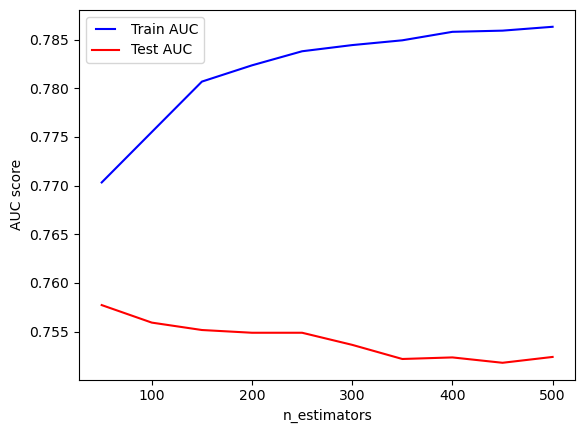

In [186]:
# generates a line graph of the training AUC and testing AUC for comparison
line1, = plt.plot(n_estimator_lst, train_auc, 'b', label="Train AUC")
line2, = plt.plot(n_estimator_lst, test_auc, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

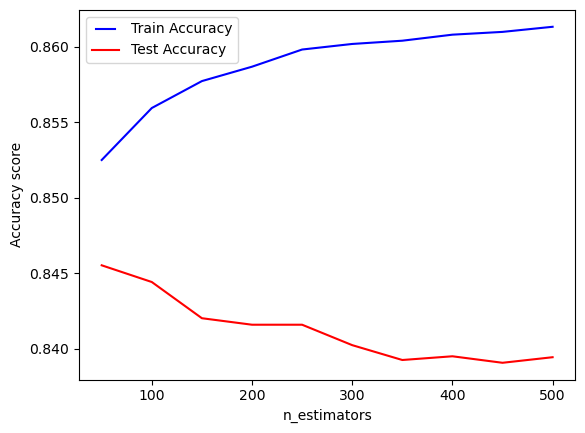

In [187]:
# generates a line graph of the training accuracy and testing accuracy for comparison
line1, = plt.plot(n_estimator_lst, train_accuracy, 'b', label="Train Accuracy")
line2, = plt.plot(n_estimator_lst, test_accuracy, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

Accuracy and AUC decline as more estimators are added. For this reason, we should keep n_estimators low. The optimal value from those tested is 50.

In [189]:
# re-running the model with the optimal value for n_estimators
xgb = XGBClassifier(n_estimators=50,random_state=890)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [190]:
perf(y_test, y_pred) # output metics

Accuracy,Recall,Precision,F1 Score,AUC
0.845525,0.757715,0.793270,0.772644,0.757715


In [191]:
store_metrics('XGB') # saving these metrics for comparison across models

### Choosing the Best Model

In [193]:
metrics_df # this is the dataframe where all our stored metrics from the different models is housed

,Metric,Random Forest,Ada Boost,Gradient Boost,XGB
0,Accuracy,0.838216,0.845034,0.846631,0.845525
1,AUC,0.749069,0.747785,0.757361,0.757715


The best of our tuned ensemble models is Gradient Boost, with the highest accuracy the second highest AUC, similar to XGB at .757.

In [195]:
# running the best model
best_model = GradientBoostingClassifier(n_estimators=100,random_state=890)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

In [196]:
perf(y_test, y_pred)

Accuracy,Recall,Precision,F1 Score,AUC
0.846631,0.757361,0.795790,0.773294,0.757361


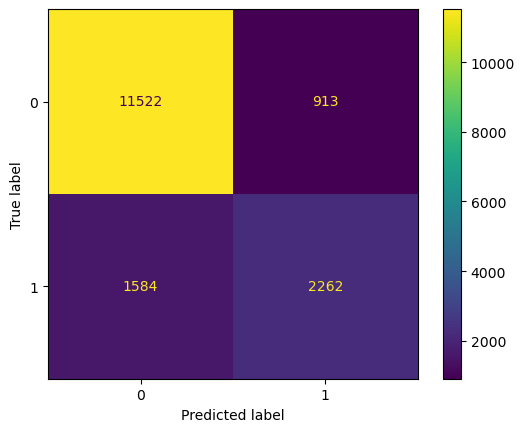

In [197]:
# Confusion matrix for the best model
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

### Step 3: Predictor

In this section, a single prediction can be made using our best model. To change the input, alter the user_input dictionary. Values should match bin formats from the initial dataset verbatim, except for hours, education years, and age, which can be entered as a number.

#### User Input

In [201]:
predictor_df = abt_prepped.copy()

In [202]:
predictor_df = predictor_df.drop(predictor_df.index)

In [203]:
predictor_df.head()

,flag,y,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_0_25,age_bin_26_30_71_100,age_bin_31_35_61_70,age_bin_36_40_56_60,age_bin_40_55,capital_gl_0,capital_gl_less_thn_0,capital_gl_greater_thn_0,hours_per_week_0_30,hours_per_week_31_40,hours_per_week_71_100,hours_per_week_41_50_61_70,hours_per_week_51_60,workclass_no_income,workclass_income


In [204]:
user_input = {'hrs': 48, 'occ': 'b. Mid - Low', 'msr': 'c. High', 'gain': 'c. > 0', 'race-sex': 'b. Mid', 'ed_yrs': 12, 'ed': 'e. High', 'class': 'b. income', 'age': 58}

In [205]:
abt['hours_per_week_bin'].unique()

array(['b. 31-40', 'a. 0-30', 'd. 41-50 & 61-70', 'c. 71-100', 'e. 51-60'],
      dtype=object)

In [206]:
if 26 <= user_input['age'] <= 30 or user_input['age'] >= 71:
    age_group = 'b. 26-30 & 71-100'
elif 31 <= user_input['age'] <= 35 or user_input['age'] >= 61:
    age_group = 'c. 31-35 & 61-70'
elif 36 <= user_input['age'] <= 40 or user_input['age'] >= 56:
    age_group = 'd. 36-40 & 56-60'
elif 41 <= user_input['age'] <= 55:
    age_group = 'e. 40-55'
else:
    age_group = 'a. 0-25'

print(age_group)

d. 36-40 & 56-60


In [207]:
if 0 <= user_input['ed_yrs'] <= 8:
    ed_group = 'a. 0-8'
elif 9 <= user_input['ed_yrs'] <= 12:
    ed_group = 'b. 9-12'
elif user_input['ed_yrs'] == 13:
    ed_group = 'c. 13'
elif user_input['ed_yrs'] == 14:
    ed_group = 'd. 14'
elif user_input['ed_yrs'] >= 15:
    ed_group = 'e. 15+'
else:
    ed_group = 'Unknown'

print(ed_group)

b. 9-12


In [208]:
if 0 <= user_input['hrs'] <= 30:
    hrs_group = 'a. 0-30'
elif 31 <= user_input['hrs'] <= 40:
    hrs_group = 'b. 31-40'
elif 41 <= user_input['hrs'] <= 50 or 61 <= user_input['hrs'] <= 70:
    hrs_group = 'd. 41-50 & 61-70'
elif 51 <= user_input['hrs'] <= 60:
    hrs_group = 'e. 51-60'
elif 71 <= user_input['hrs'] <= 100:
    hrs_group = 'c. 71-100'
else:
    hrs_group = 'Unknown'

print(hrs_group)

d. 41-50 & 61-70


In [209]:
pred_input = user_input

In [210]:
pred_input['age'] = age_group

In [211]:
pred_input['ed_yrs'] = ed_group

In [212]:
pred_input['hrs'] = hrs_group

In [213]:
pred_input

{'hrs': 'd. 41-50 & 61-70',
 'occ': 'b. Mid - Low',
 'msr': 'c. High',
 'gain': 'c. > 0',
 'race-sex': 'b. Mid',
 'ed_yrs': 'b. 9-12',
 'ed': 'e. High',
 'class': 'b. income',
 'age': 'd. 36-40 & 56-60'}

In [214]:
# The new input needs to be encoded in the same way as the training data, so here we add the input as the first row in the dataset and perform the encoding again.
reencode = df.copy()
reencode = reencode.drop(['y','flag'], axis=1)

In [215]:
reencode.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100


In [216]:
reencode.iloc[0] = list(pred_input.values()) # add user input
reencode.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin
0,d. 41-50 & 61-70,b. Mid - Low,c. High,c. > 0,b. Mid,b. 9-12,e. High,b. income,d. 36-40 & 56-60
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100


In [217]:
# Apply encoding to each column
for col in ['occupation_bin', 'msr_bin', 'race_sex_bin', 'education_num_bin']:
    reencode[col + '_Encoded'] = encode_column(reencode[col])

In [218]:
reencode.drop('education_bin', axis=1, inplace=True)

Now we must encode the nominal features.

In [220]:
# One-Hot Encoding for nominal columns
nominal_columns = ['age_bin', 'capital_gl_bin', 'hours_per_week_bin', 'workclass_bin']
reencode = pd.get_dummies(reencode, columns=nominal_columns)

In [221]:
# Drop the old columns, keeping only the encoded columns
reencode = reencode.iloc[:,4:]   
reencode.head()

,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55,capital_gl_bin_a. = 0,capital_gl_bin_b. < 0,capital_gl_bin_c. > 0,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,workclass_bin_a. no income,workclass_bin_b. income
0,2,3,2,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1
1,5,3,3,3,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,1,2,3,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,1,3,2,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4,5,3,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [222]:
# Some models cannot accept special characters in the column name, so we must rename them.
# Define a mapping for renaming columns
rename_mapping = {
    'age_bin_a. 0-25': 'age_bin_0_25',
    'age_bin_b. 26-30 & 71-100': 'age_bin_26_30_71_100',
    'age_bin_c. 31-35 & 61-70': 'age_bin_31_35_61_70',
    'age_bin_d. 36-40 & 56-60': 'age_bin_36_40_56_60',
    'age_bin_e. 40-55': 'age_bin_40_55',
    'capital_gl_bin_a. = 0': 'capital_gl_0',
    'capital_gl_bin_b. < 0': 'capital_gl_less_thn_0',
    'capital_gl_bin_c. > 0': 'capital_gl_greater_thn_0',
    'hours_per_week_bin_a. 0-30': 'hours_per_week_0_30',
    'hours_per_week_bin_b. 31-40': 'hours_per_week_31_40',
    'hours_per_week_bin_c. 71-100': 'hours_per_week_71_100',
    'hours_per_week_bin_d. 41-50 & 61-70': 'hours_per_week_41_50_61_70',
    'hours_per_week_bin_e. 51-60': 'hours_per_week_51_60',
    'workclass_bin_a. no income': 'workclass_no_income',
    'workclass_bin_b. income': 'workclass_income'
}

# Rename columns
reencode.rename(columns=rename_mapping, inplace=True)

In [223]:
reencode.head()

,occupation_bin_Encoded,msr_bin_Encoded,race_sex_bin_Encoded,education_num_bin_Encoded,age_bin_0_25,age_bin_26_30_71_100,age_bin_31_35_61_70,age_bin_36_40_56_60,age_bin_40_55,capital_gl_0,capital_gl_less_thn_0,capital_gl_greater_thn_0,hours_per_week_0_30,hours_per_week_31_40,hours_per_week_71_100,hours_per_week_41_50_61_70,hours_per_week_51_60,workclass_no_income,workclass_income
0,2,3,2,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1
1,5,3,3,3,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
2,1,2,3,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,1,3,2,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4,5,3,1,3,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [224]:
# Keep only the first row (the new user input data)
first_row_df = reencode.iloc[:1]

#### Prediction

In [226]:
pred=best_model.predict(first_row_df)

In [227]:
print(f"Predicted income level is {'>$50K' if pred == 1 else '<=$50K'}")

Predicted income level is >$50K


In [228]:
probabilities = best_model.predict_proba(first_row_df)

In [229]:
probabilities

array([[0.35040974, 0.64959026]])

Using our sample predictors, the model predicted a 65% probability that the predicted value is 1, e.g., >50K.

##### (End)